In [1]:
import sys, subprocess

def pip_install(pkg):
    if hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix):
        pass
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

for pkg in [
    'transformers>=4.44.0',
    'datasets>=2.19.0',
    'accelerate>=0.33.0',
    'evaluate>=0.4.2',
    'scikit-learn>=1.4.0',
    'pandas>=2.2.0',
    'matplotlib>=3.8.0'
]:
    pip_install(pkg)

In [3]:
from google.colab import files
print("Silakan upload file CSV dataset Anda…")
uploaded = files.upload()  # pilih file .csv

# Ambil nama file pertama yang diupload
if len(uploaded) == 0:
    raise SystemExit("Tidak ada file yang diupload. Jalankan cell ini lagi dan pilih file CSV.")

datafile = list(uploaded.keys())[0]
print("Dataset file:", datafile)

# Coba baca dengan beberapa encoding umum dan semicolon delimiter
read_ok = False
for enc in ["utf-8", "utf-8-sig", "latin-1"]:
    try:
        df = pd.read_csv(datafile, encoding=enc, sep=';')
        read_ok = True
        print(f"Berhasil membaca CSV dengan encoding: {enc}")
        break
    except Exception as e:
        last_err = e

if not read_ok:
    raise last_err

print("Ukuran data:", df.shape)
print("Lima baris teratas:")
print(df.head())
print("Kolom:", df.columns.tolist())

Silakan upload file CSV dataset Anda…


Saving Dataset Review Product di Shopee dan Tokopedia.csv to Dataset Review Product di Shopee dan Tokopedia.csv
Dataset file: Dataset Review Product di Shopee dan Tokopedia.csv
Berhasil membaca CSV dengan encoding: latin-1
Ukuran data: (68346, 3)
Lima baris teratas:
   review_id                                             review  rating
0          0                                      slow delivery       1
1          1              Dateng goods do not conform pesanan??       1
2          2                             PSN k its 20 other DTG       1
3          3  I am expected that it have a frame and painted...       1
4          4                   The product quality is not good.       1
Kolom: ['review_id', 'review', 'rating']


In [4]:
text_candidates = ['review', 'ulasan', 'text', 'teks', 'content', 'komentar', 'review_text']
label_candidates = ['label', 'sentimen', 'sentiment', 'target', 'kelas', 'rating']

text_col = None
label_col = None

for c in df.columns:
    c_low = c.lower()
    if text_col is None and any(k in c_low for k in text_candidates):
        text_col = c
    if label_col is None and any(k in c_low for k in label_candidates):
        label_col = c

if text_col is None:
    raise ValueError("Tidak menemukan kolom teks ulasan. Pastikan ada kolom seperti 'review' atau 'ulasan'.")
if label_col is None:
    raise ValueError("Tidak menemukan kolom label. Pastikan ada kolom seperti 'label' atau 'sentimen'.")

# Rename agar konsisten
if text_col != 'text':
    df.rename(columns={text_col: 'text'}, inplace=True)
if label_col != 'label':
    df.rename(columns={label_col: 'label'}, inplace=True)

# Bersihkan nilai NaN
df = df.dropna(subset=['text', 'label']).reset_index(drop=True)

# Normalisasi label
# Jika string: map ke {negatif:0, positif:1}. Jika angka: pastikan int 0/1.
label_map_text = {
    'negatif': 0, 'negative': 0, 'neg': 0, 'bad': 0, 'buruk': 0,
    'positif': 1, 'positive': 1, 'pos': 1, 'good': 1, 'bagus': 1
}

if df['label'].dtype == object:
    df['label_norm'] = df['label'].astype(str).str.lower().str.strip().map(label_map_text)
else:
    # Anggap sudah numerik (ratings 1-5)
    # Map ratings 1, 2, 3 to 0 (negative) and 4, 5 to 1 (positive)
    df['label_norm'] = df['label'].apply(lambda x: 0 if x in [1, 2, 3] else 1)


# Validasi label
if df['label_norm'].isna().any():
    # Ada label yang tidak dikenali; coba konversi ke int bila memungkinkan
    try:
        df['label_norm'] = df['label'].astype(int)
    except:
        bad = df[df['label_norm'].isna()]['label'].unique()[:20]
        raise ValueError(f"Beberapa label tidak dikenali. Contoh: {bad}.\nPerbaiki label menjadi 0/1 atau positif/negatif.")

# Pastikan hanya 0/1
unique_labels = sorted(pd.unique(df['label_norm']))
print("Label unik setelah normalisasi:", unique_labels)
if not set(unique_labels).issubset({0,1}):
    raise ValueError(f"Label harus biner 0/1. Ditemukan: {unique_labels}")

# Opsi: batasi ke 100 data (kalau diminta/guna testing cepat)
LIMIT = None  # set ke angka (mis. 100) untuk sampling cepat
if LIMIT is not None and LIMIT < len(df):
    df = df.sample(n=LIMIT, random_state=SEED).reset_index(drop=True)

Label unik setelah normalisasi: [np.int64(0), np.int64(1)]


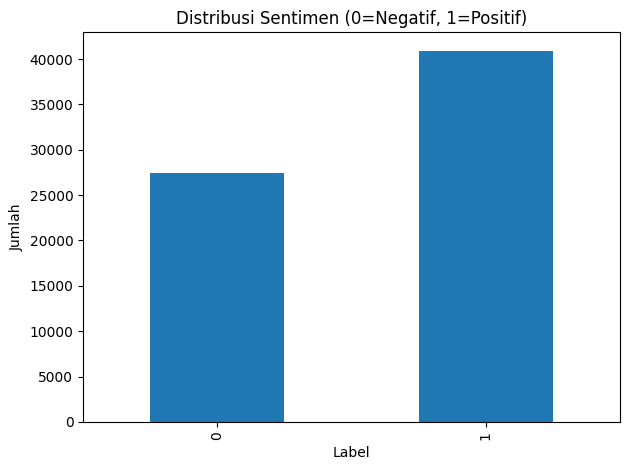

In [5]:
os.makedirs('outputs', exist_ok=True)
vc = df['label_norm'].value_counts().sort_index()
plt.figure()
vc.plot(kind='bar')
plt.title('Distribusi Sentimen (0=Negatif, 1=Positif)')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.savefig('outputs/sentiment_distribution.png', dpi=150)
plt.show()

In [6]:
# Ensure 'text' and 'label_norm' columns are ready from previous steps
# Assuming the column containing review text is now named 'text' and the normalized label is 'label_norm'
train_df, test_df = train_test_split(
    df[['text','label_norm']], # Use the renamed 'text' column and the normalized 'label_norm' column
    test_size=0.2,
    random_state=SEED,
    stratify=df['label_norm']
)
print("Train:", train_df.shape, "Test:", test_df.shape)

Train: (54676, 2) Test: (13670, 2)


In [7]:
model_name_primary = 'indobenchmark/indobert-base-p1'
model_name_fallback = 'bert-base-multilingual-cased'

try:
    tokenizer = AutoTokenizer.from_pretrained(model_name_primary)
    model_name = model_name_primary
except Exception as e:
    print("Gagal memuat IndoBERT, pakai fallback mBERT. Alasan:", e)
    tokenizer = AutoTokenizer.from_pretrained(model_name_fallback)
    model_name = model_name_fallback

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import datasets as hfds

# Pastikan kolom text tidak ada NaN dan semuanya string
train_df = train_df.dropna(subset=['text']).reset_index(drop=True)
test_df = test_df.dropna(subset=['text']).reset_index(drop=True)

train_df['text'] = train_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

# Konversi label ke integer kalau belum
train_df['label_norm'] = train_df['label_norm'].astype(int)
test_df['label_norm'] = test_df['label_norm'].astype(int)


# Buat dataset HuggingFace
train_hf = hfds.Dataset.from_pandas(train_df.rename(columns={'label_norm':'label'}), preserve_index=False)
test_hf  = hfds.Dataset.from_pandas(test_df.rename(columns={'label_norm':'label'}), preserve_index=False)


# Tokenisasi
def tokenize_batch(batch):
    return tokenizer(batch['text'], padding=False, truncation=True, max_length=128)

train_tokenized = train_hf.map(tokenize_batch, batched=True)
test_tokenized  = test_hf.map(tokenize_batch, batched=True)

# Data collator
collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/54676 [00:00<?, ? examples/s]

Map:   0%|          | 0/13670 [00:00<?, ? examples/s]

In [9]:
acc_metric = evaluate.load('accuracy')
f1_metric  = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = acc_metric.compute(predictions=preds, references=labels)['accuracy']
    f1  = f1_metric.compute(predictions=preds, references=labels, average='weighted')['f1']
    return {"accuracy": acc, "f1": f1}

In [10]:
args = TrainingArguments(
    output_dir='outputs/checkpoints',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    seed=SEED,
    report_to='none'
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-2303354444.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
train_result = trainer.train()
print(train_result)

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.148200,0.126513,0.921946,0.922632
2,0.124500,0.119590,0.923263,0.923971
3,0.114700,0.112242,0.924799,0.925494


TrainOutput(global_step=10254, training_loss=0.12914391449373416, metrics={'train_runtime': 971.5488, 'train_samples_per_second': 168.831, 'train_steps_per_second': 10.554, 'total_flos': 421434021812640.0, 'train_loss': 0.12914391449373416, 'epoch': 3.0})



==== HASIL EVALUASI TEST ====
eval_loss: 0.1122
eval_accuracy: 0.9248
eval_f1: 0.9255
eval_runtime: 6.3321
eval_samples_per_second: 2158.8440
eval_steps_per_second: 67.5920
epoch: 3.0000

Classification Report:
               precision    recall  f1-score   support

           0     0.8431    0.9985    0.9143      5489
           1     0.9989    0.8753    0.9330      8181

    accuracy                         0.9248     13670
   macro avg     0.9210    0.9369    0.9236     13670
weighted avg     0.9363    0.9248    0.9255     13670



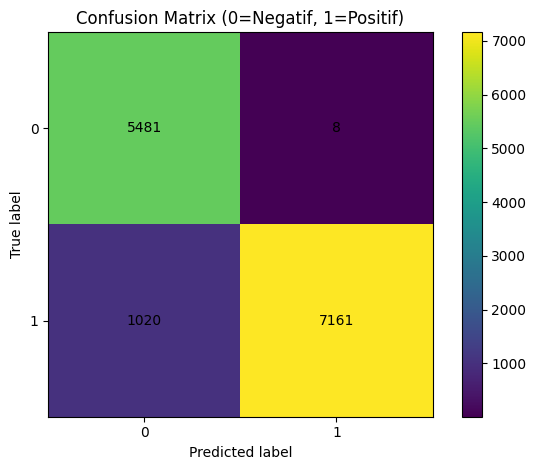

Model & tokenizer disimpan ke: outputs/model-best

Akurasi: 0.9248 (MEMENUHI) target > 0.85
F1-score (weighted): 0.9255


In [12]:
eval_metrics = trainer.evaluate(eval_dataset=test_tokenized)
print("\n==== HASIL EVALUASI TEST ====")
for k,v in eval_metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(k, v)

# Prediksi per-sampel dan simpan
pred_logits = trainer.predict(test_tokenized).predictions
pred_labels = pred_logits.argmax(axis=-1)
true_labels = np.array(test_tokenized['label'])

# Confusion Matrix & Classification Report
cm = confusion_matrix(true_labels, pred_labels, labels=[0,1])
print("\nClassification Report:\n", classification_report(true_labels, pred_labels, digits=4))

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (0=Negatif, 1=Positif)')
plt.colorbar()
plt.xticks([0,1],[0,1])
plt.yticks([0,1],[0,1])
plt.xlabel('Predicted label')
plt.ylabel('True label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.tight_layout()
plt.savefig('outputs/confusion_matrix.png', dpi=150)
plt.show()

# Simpan ringkasan metrik
with open('outputs/metrics.txt', 'w') as f:
    for k,v in eval_metrics.items():
        f.write(f"{k}: {v}\n")

# Simpan prediksi ke CSV
pred_df = pd.DataFrame({
    'text': test_df['text'].values,
    'true_label': true_labels,
    'pred_label': pred_labels
})
pred_df.to_csv('outputs/predictions_test.csv', index=False)

# Simpan model & tokenizer
save_dir = 'outputs/model-best'
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)
print(f"Model & tokenizer disimpan ke: {save_dir}")

# Cek target akurasi > 85%
acc = eval_metrics.get('eval_accuracy') or eval_metrics.get('accuracy')
f1v = eval_metrics.get('eval_f1') or eval_metrics.get('f1')
if acc is not None:
    print(f"\nAkurasi: {acc:.4f} ({'MEMENUHI' if acc>=0.85 else 'BELUM MEMENUHI'}) target > 0.85")
if f1v is not None:
    print(f"F1-score (weighted): {f1v:.4f}")

In [13]:
os.makedirs('project', exist_ok=True)
import shutil
shutil.copy2(datafile, os.path.join('project', os.path.basename(datafile)))

# Simpan salinan script ini
nb_path = 'project/run_notebook_instructions.txt'
with open(nb_path, 'w') as f:
    f.write(
"""
CATATAN:
- Notebook ini berisi langkah lengkap training IndoBERT untuk analisis sentimen.
- File utama yang relevan:
  - outputs/ : gambar visualisasi, metrics.txt, predictions_test.csv, model-best/
  - project/ : salinan dataset & dokumen README.md (akan dibuat di cell GitHub)
- Anda dapat menyalin setiap CELL ke Google Colab jika file ini diunduh sebagai .py
"""
    )
print("Salinan dataset & catatan disiapkan di folder project/")

Salinan dataset & catatan disiapkan di folder project/


In [17]:
def save_notebook_with_output(notebook_name):
    import IPython
    ipynb = IPython.get_ipython().get_parent()
    import json
    from google.colab import _message
    _message.blocking_request('get_ipynb', {}, timeout_sec=60)
    data = _message.blocking_request('get_ipynb')
    with open(notebook_name, 'w', encoding='utf-8') as f:
        json.dump(data['ipynb'], f, ensure_ascii=False)